# For Jax Cosmo

In [1]:
import sys
sys.path.append('../reference/jax-cosmo/jax_cosmo-master/')

Import other libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sacc
import jax_cosmo as jc

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15
save_plots = False

In [3]:
saccfile = sacc.Sacc.load_fits('../data/cls_DESY1.fits')

In [4]:
tracers_names = list(saccfile.tracers.keys())
nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])

# Redshift Distribution (Galaxy Clustering)

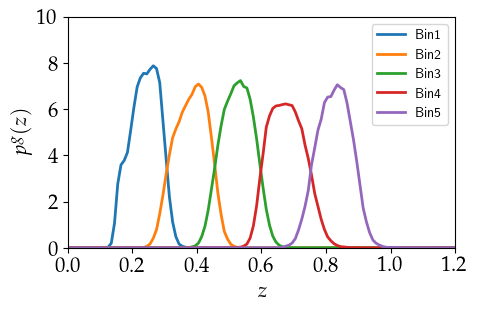

In [5]:
plt.figure(figsize=(5,3))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p^{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_gc.pdf', bbox_inches = 'tight')
plt.show()

# Using Jax Cosmo

If we want to use JAX cosmo to get the redshift distributions. 

In [6]:
jax_nz_gc = list()
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    zmax = max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float32'),distribution.nz.astype('float32'), zmax = zmax)
    jax_nz_gc.append(jaxred)

In [7]:
redshifts = distribution.z.astype('float32')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


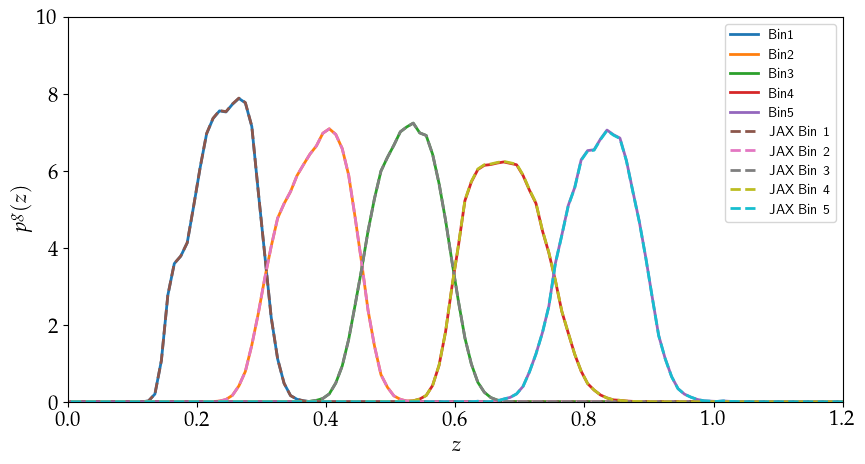

In [8]:
plt.figure(figsize=(10,5))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_gc):
    plt.plot(redshifts, jax_nz_gc[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_gc_jax.pdf', bbox_inches = 'tight')
plt.show()

# Redshift Distribution (Weak Lensing)

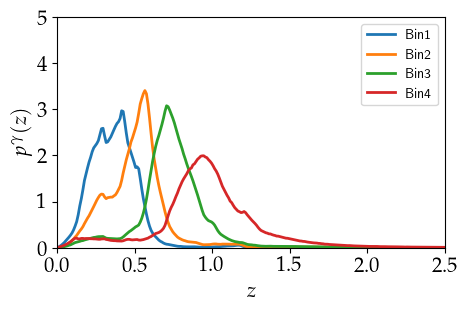

In [9]:
plt.figure(figsize=(5,3))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl.pdf', bbox_inches = 'tight')
plt.show()

# Using JAX Cosmo

In [10]:
jax_nz_wl = list()
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    zmax = max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float32'),distribution.nz.astype('float32'), zmax = zmax)
    jax_nz_wl.append(jaxred)

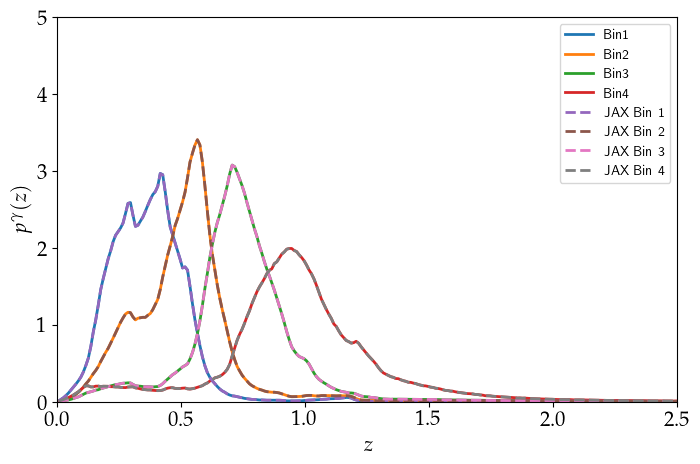

In [11]:
plt.figure(figsize=(8,5))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_wl):
    plt.plot(redshifts, jax_nz_wl[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl_jax.pdf', bbox_inches = 'tight')
plt.show()

# Scale Cuts

In [12]:
# Now impose scale cuts for galaxy clustering and galaxy-galaxy lensing
# Maximum multipole for the 5 different galaxy redshift bins
lmaxs = [145, 225, 298, 371, 435]

In [13]:
def scale_cuts(saccfile, lmaxs):
    # First we remove all B-modes
    saccfile.remove_selection(data_type='cl_bb')
    saccfile.remove_selection(data_type='cl_be')
    saccfile.remove_selection(data_type='cl_eb')
    saccfile.remove_selection(data_type='cl_0b')

    for i, lmax in enumerate(lmaxs):
        tname_1 = f'DESgc__{i}'
        
        # Remove from galaxy clustering
        saccfile.remove_selection(data_type='cl_00', tracers=(tname_1, tname_1), ell__gt=lmax)
        
        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f'DESwl__{j}'
            saccfile.remove_selection(data_type='cl_0e', tracers=(tname_2, tname_2), ell__gt=lmax)
    return saccfile

In [14]:
saccfile = scale_cuts(saccfile, lmaxs)

# Data - Galaxy Clustering 

In [15]:
def plot_data_gc(saccfile, xlabel, ylabel, ell_grid = None, theory = None, nx = 5, ylims = (1E-6, 5E-4), fontsize = 12, fname = 'data_galaxy_clustering'):
    f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))

    for counter in range(nx):

        tracername = f'DESgc__{i}'
        ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        labz = f'$p_{counter+1}(z)$'

        ax[counter].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        if theory is not None:
            ax[counter].plot(ell_grid, theory[counter], lw = 3, c = 'r')
        ax[counter].set_xlabel(xlabel, fontsize=fontsize)
        ax[counter].set_xlim(min(ell)-5, max(ell)+50)
        ax[counter].set_ylim(ylims[0], ylims[1])
        ax[counter].set_xscale("log")
        ax[counter].set_yscale("log")
        ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[counter].tick_params(axis='both', which='both', length=0)
        ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
        if counter==0 :
            ax[counter].set_ylabel(ylabel, fontsize=fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fname and save_plots:
        plt.savefig(f'../plots/{fname}.pdf', bbox_inches='tight')
    plt.show()

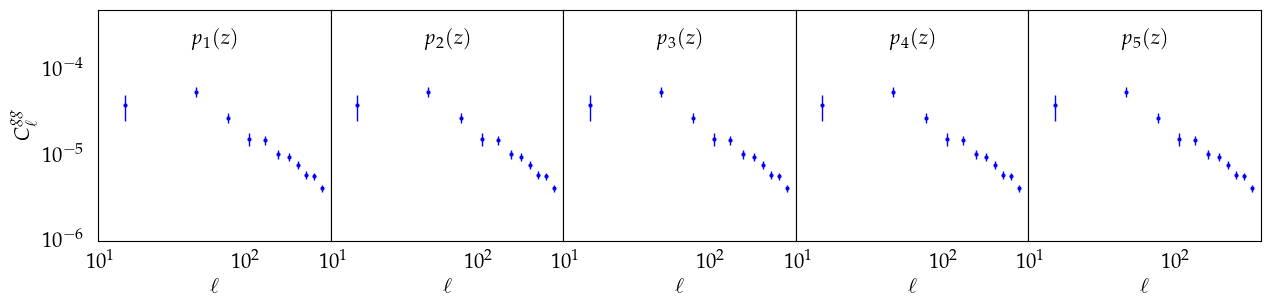

In [16]:
yLabel = r'$C_{\ell}^{gg}$'
xLabel = r'$\ell$'
plot_data_gc(saccfile, xLabel, yLabel, fontsize=fontSize, fname = 'carlos_data_gc')

In [17]:
ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_00', 'DESgc__0', 'DESgc__0', return_cov=True, return_ind=True)

# Using JAX 
To get the $C_{\ell}^{gg}$. Some functions are borrowed from the JAX cosmo paper. 

In [18]:
def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    bias_1, bias_2, bias_3, bias_4, bias_5 = bias
    return np.array([
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b, cosmo.h, cosmo.n_s,
        mparam_1, mparam_2, mparam_3, mparam_4,
        dz1, dz2, dz3, dz4,
        a_ia_param, eta_param,
        bias_1, bias_2, bias_3, bias_4, bias_5
    ])
    
def unpack_params_vec(params):
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=-1.0, Omega_k=0., wa=0.)
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    bias = params[15:20]
    return cosmo, [mparam_1, mparam_2, mparam_3, mparam_4], [dz1,dz2,dz3,dz4], [a_ia_param, eta_param], bias

def get_index_pairs(saccfile, tracer1="gc", tracer2="gc"):
    tracer_combinations = saccfile.get_tracer_combinations()
    cl_index = list()
    for pair in tracer_combinations:
        if tracer1 in pair[0] and tracer2 in pair[1]:
            cl_index.append((int(pair[0][-1]), int(pair[1][-1])))
    return cl_index

In [19]:
cosmo =  jc.Cosmology(sigma8=0.801, Omega_c=0.2545, Omega_b=0.0485, h=0.682, n_s=0.971, 
                      w0=-1., Omega_k=0., wa=0.)

params = get_params_vec(cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

cosmo, multiplicative, deltaz, (a_ia_param, eta_param), bias = unpack_params_vec(params) 

nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz)]
gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias] 
b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

probes_gc = [jc.probes.NumberCounts(jax_nz_gc, gc_biases)]
probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
probes_gc_wl = probes_gc + probes_wl

In [20]:
%%capture
ell_grid_gc = np.logspace(1, np.log10(450))
idx_pairs_gc = get_index_pairs(saccfile, 'gc', 'gc')
cls_gc = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc, index_pairs = idx_pairs_gc)

In [21]:
%%capture
idx_pairs_gc_wl = get_index_pairs(saccfile, 'gc', 'wl')
cls_gc_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc_wl, index_pairs = idx_pairs_gc_wl)

In [22]:
%%capture
ell_grid_wl = np.logspace(np.log10(10), np.log10(11560))
idx_pairs_wl = get_index_pairs(saccfile, 'wl', 'wl')
cls_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_wl, probes_wl, index_pairs = idx_pairs_wl)

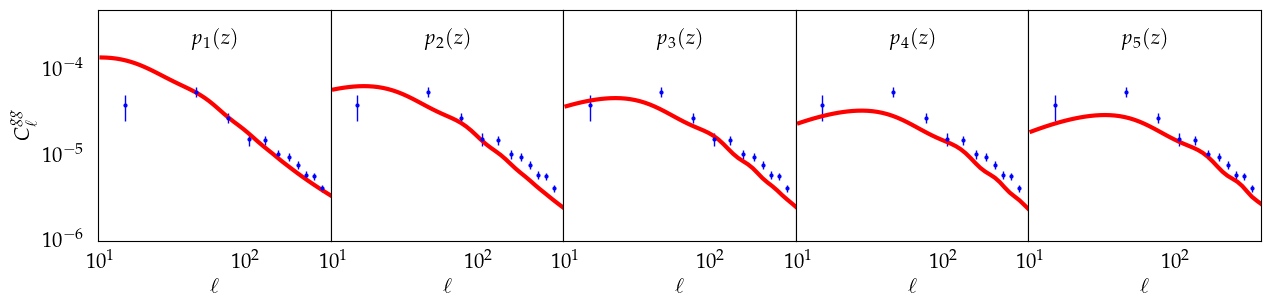

In [23]:
plot_data_gc(saccfile, xLabel, yLabel, ell_grid = ell_grid_gc, theory = cls_gc, fontsize=fontSize, fname = 'carlos_data_gc')

# Data - Galaxy Clustering and Weak Lensing

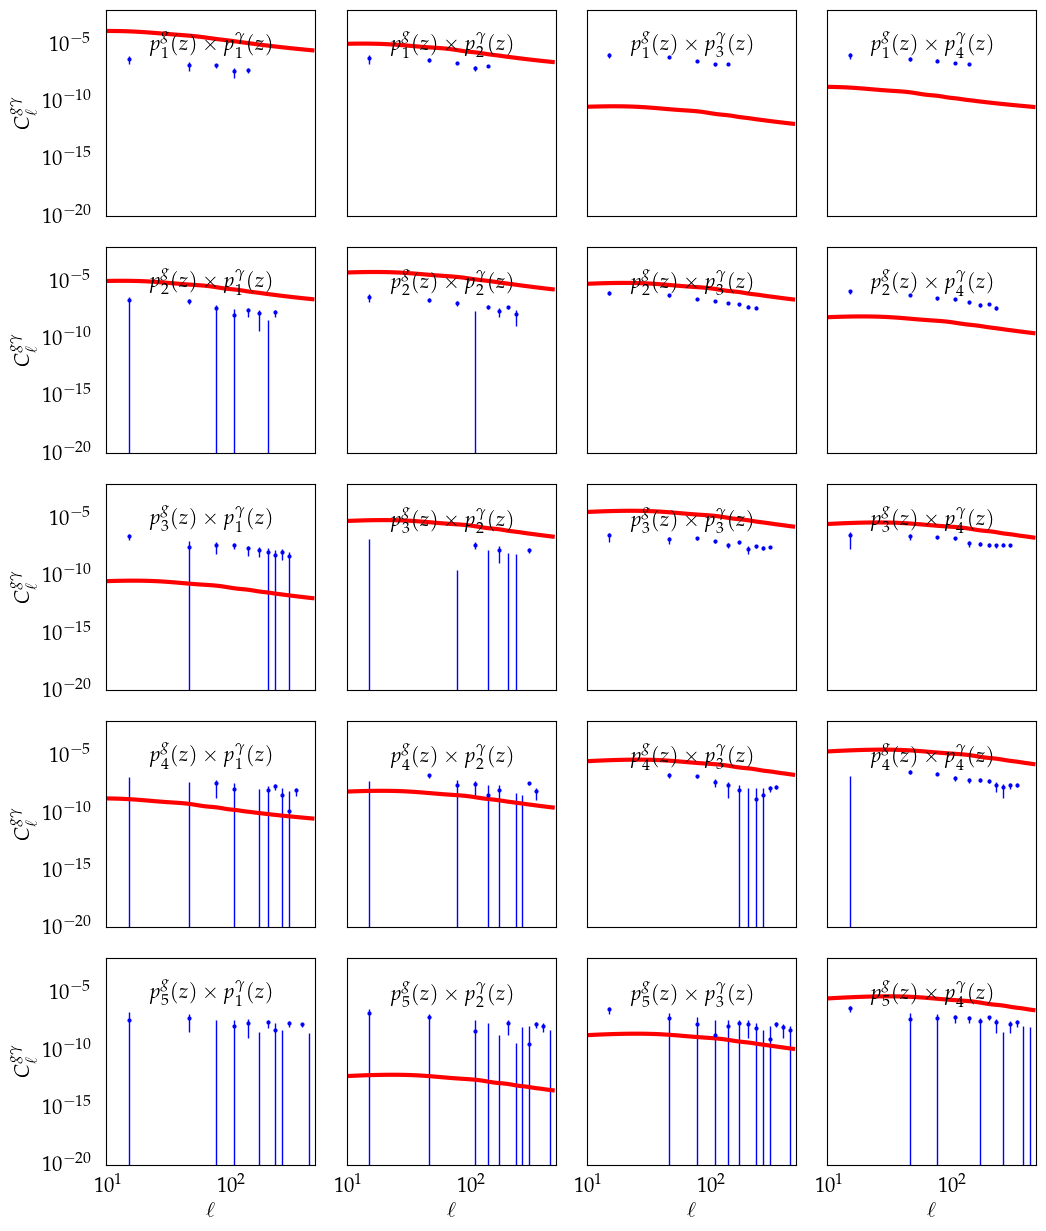

In [24]:
yLabel = r'$C_{\ell}^{g\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-20, 1E-2]
fontsize = fontSize

f, ax = plt.subplots(nbin_gc, nbin_wl, sharex=True, sharey = True, figsize = (12, 15))
counter = 0
for i in range(nbin_gc):
    for j in range(nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{g}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_gc = f'DESgc__{i}'
        tracername_wl = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_0e', tracername_gc, tracername_wl, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[i,j].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[i,j].plot(ell_grid_gc, cls_gc_wl[counter], lw = 3, c = 'r')
        ax[i,j].set_xlim(min(ell)-5, max(ell)+50)
        ax[i,j].set_ylim(ylims[0], ylims[1])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if j==0 :
            ax[i,j].set_ylabel(yLabel, fontsize=fontsize)
        if i==nbin_gc-1:
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            
        counter += 1

f.subplots_adjust(wspace=0.15)
f.subplots_adjust(hspace=0.15)
if save_plots:
    plt.savefig(f'../plots/carlos_data_gc_shear.pdf', bbox_inches='tight')
plt.show()

# Data - Weak Lensing

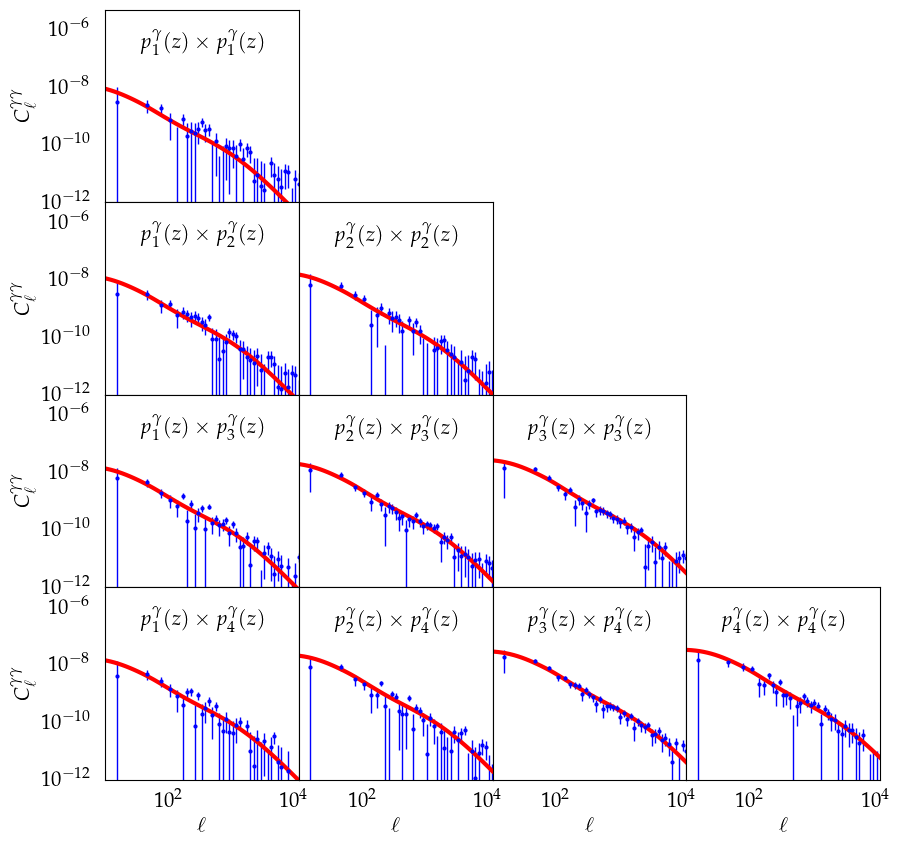

In [25]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 5E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, 4):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 3, c = 'r')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
if save_plots:
    plt.savefig(f'../plots/carlos_data_shear_shear.pdf', bbox_inches='tight')
plt.show()

# Extract the Data Vector and the Covariance

In [26]:
def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    indices = []
    idxpositions = []
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        _, _, ind = saccfile.get_ell_cl('cl_00', tracer_name, tracer_name, return_cov=False, return_ind=True)
        indices += list(ind)
        
    idxpositions.append(len(indices))

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_0e', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
            
    idxpositions.append(len(indices))
        
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, 4):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_ee', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
    idxpositions.append(len(indices))

    indices = np.array(indices)
    idxpositions = np.hstack([np.zeros(1), np.array(idxpositions)])
    
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return data, covariance, idxpositions

In [27]:
data, covariance, idxpositions = extract_data_covariance(saccfile)

In [28]:
scaledcov = covariance/np.sqrt(np.outer(np.diag(covariance), np.diag(covariance)))
delta = np.diff(idxpositions)
mid = np.array(idxpositions[:-1] + delta/2, dtype = int)

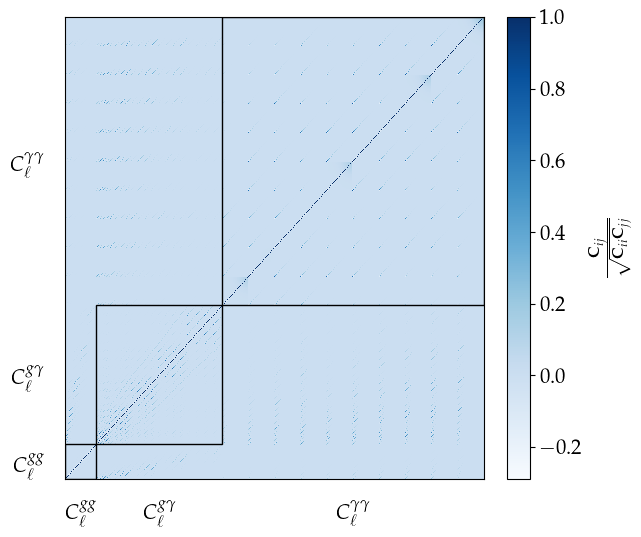

In [29]:
column_labels = [r'$C_{\ell}^{gg}$', r'$C_{\ell}^{g\gamma}$', r'$C_{\ell}^{\gamma\gamma}$']
colormap = plt.cm.Blues

fig, ax = plt.subplots(figsize = (6, 6))

heatmap = ax.pcolor(scaledcov, cmap=colormap, rasterized=True)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=fontSize)
cbar.ax.tick_params(labelsize=fontSize) 

rect1 = patches.Rectangle((idxpositions[0], idxpositions[0]), delta[0], delta[0], linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((idxpositions[1], idxpositions[1]), delta[1], delta[1], linewidth=1, edgecolor='k', facecolor='none')
rect3 = patches.Rectangle((idxpositions[2], idxpositions[2]), delta[2], delta[2], linewidth=1, edgecolor='k', facecolor='none')
# rect4 = patches.Rectangle((800, 800), 100, 100, linewidth=1, edgecolor='k', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
# ax.add_patch(rect4)

ax.set_xticks(mid, minor=False)
ax.set_yticks(mid, minor=False)

ax.set_xticklabels(column_labels, minor=False, fontsize=fontSize)
ax.set_yticklabels(column_labels, minor=False, fontsize=fontSize)
ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)

if save_plots:
    plt.savefig(f'../plots/carlos_covariance.pdf', bbox_inches='tight')

plt.show()

# Tracer Combinations

In [30]:
tracer_combinations = saccfile.get_tracer_combinations()

In [31]:
tracer_combinations

[('DESgc__0', 'DESgc__0'),
 ('DESgc__1', 'DESgc__1'),
 ('DESgc__2', 'DESgc__2'),
 ('DESgc__3', 'DESgc__3'),
 ('DESgc__4', 'DESgc__4'),
 ('DESgc__0', 'DESwl__0'),
 ('DESgc__0', 'DESwl__1'),
 ('DESgc__0', 'DESwl__2'),
 ('DESgc__0', 'DESwl__3'),
 ('DESgc__1', 'DESwl__0'),
 ('DESgc__1', 'DESwl__1'),
 ('DESgc__1', 'DESwl__2'),
 ('DESgc__1', 'DESwl__3'),
 ('DESgc__2', 'DESwl__0'),
 ('DESgc__2', 'DESwl__1'),
 ('DESgc__2', 'DESwl__2'),
 ('DESgc__2', 'DESwl__3'),
 ('DESgc__3', 'DESwl__0'),
 ('DESgc__3', 'DESwl__1'),
 ('DESgc__3', 'DESwl__2'),
 ('DESgc__3', 'DESwl__3'),
 ('DESgc__4', 'DESwl__0'),
 ('DESgc__4', 'DESwl__1'),
 ('DESgc__4', 'DESwl__2'),
 ('DESgc__4', 'DESwl__3'),
 ('DESwl__0', 'DESwl__0'),
 ('DESwl__0', 'DESwl__1'),
 ('DESwl__0', 'DESwl__2'),
 ('DESwl__0', 'DESwl__3'),
 ('DESwl__1', 'DESwl__1'),
 ('DESwl__1', 'DESwl__2'),
 ('DESwl__1', 'DESwl__3'),
 ('DESwl__2', 'DESwl__2'),
 ('DESwl__2', 'DESwl__3'),
 ('DESwl__3', 'DESwl__3')]

# Band Window Matrix

$$
C_{\ell, ij}^{\textrm{binned}} = W^{\textrm{T}}_{\ell, ij}C_{\ell,ij}
$$

In [32]:
idx = saccfile.indices(data_type='cl_00', tracers=('DESgc__0', 'DESgc__0'))
window = saccfile.get_bandpower_windows(idx)

In [33]:
ells = window.values
bandwindow = window.weight

In [34]:
def get_data_type(tracer_combination):
    if 'gc' in tracer_combination[0] and 'gc' in tracer_combination[1]:
        dtype = 'cl_00'
    elif 'gc' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_0e'
    elif 'wl' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_ee'
    return dtype

In [35]:
get_data_type(tracer_combinations[0])

'cl_00'

In [36]:
get_data_type(tracer_combinations[5])

'cl_0e'

In [37]:
get_data_type(tracer_combinations[-1])

'cl_ee'

In [43]:
tracer = saccfile.tracers['DESgc__0']

In [44]:
tracer.quantity

'galaxy_density'

In [45]:
np.average(tracer.z, weights=tracer.nz)

0.23969977632108197